In [1]:
import sys
import os
import numpy as np
import time
import random
from os import walk
import pathlib
from PIL import Image

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau

import models
from utils.metrics import multi_acc, iou_score

In [2]:
NO_OF_EPOCHS = 200
BATCH_SIZE = 24
IMAGE_SIZE = (256, 256)

SEED = 50

CHECKPOINT_PATH = pathlib.Path("./pretrained/model_checkpoint.pt")
FINAL_PATH = pathlib.Path("./pretrained/model_final.pt")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
def seed_torch(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True


class SegmentationImageDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        _, _, self.filenames = next(walk(image_dir))

    @classmethod
    def preprocess(cls, pil_img, normalize=True):
        pil_img = pil_img.convert('L')

        pil_img = pil_img.resize(IMAGE_SIZE)
        img_nd = np.array(pil_img)

        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)

        # HWC to CHW
        img_trans = img_nd.transpose((2, 0, 1))

        if normalize:
            img_trans = img_trans / 255

        return img_trans

    def __getitem__(self, idx):
        image = Image.open(self.image_dir + '/' + self.filenames[idx])
        mask = Image.open(self.mask_dir + '/' + self.filenames[idx])

        image = self.preprocess(image)
        mask = self.preprocess(mask)

        image = torch.from_numpy(image).type(torch.FloatTensor)
        mask = torch.from_numpy(mask).type(torch.FloatTensor)

        return image, mask

    def __len__(self):
        return len(self.filenames)


def saveCheckpoint(filename, epoch, model, optimizer, batchsize):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        "batch_size": batchsize,
    }

    # save all important stuff
    torch.save(checkpoint, filename)


In [4]:
def train(model, data_loader, criterion, optimizer, scheduler, num_epochs=5, epochs_earlystopping=10):
    logdir = './logs/' + time.strftime("%Y%m%d_%H%M%S")
    logdir = os.path.join(logdir)
    pathlib.Path(logdir).mkdir(parents=True, exist_ok=True)
    tb_writer = SummaryWriter(log_dir=logdir)

    best_acc = 0.0
    best_loss = sys.float_info.max
    best_iou = 0.0

    early_stopping = 0

    for epoch in range(num_epochs):
        result = [f"Epoch {epoch}"]
        early_stopping += 1

        for phase in ['train', 'val']:
            if phase == 'train':  # put the model in training mode
                model.train()
            else:
                # put the model in validation mode
                model.eval()

            # keep track of training and validation loss
            batch_nums = 0
            running_loss = 0.0
            running_iou = 0.0
            running_corrects = 0.0

            for (data, labels) in data_loader[phase]:
                # load the data and target to respective device
                (data, labels) = (data.to(device), labels.to(device))
                with torch.set_grad_enabled(phase == 'train'):
                    # feed the input
                    output = model(data)

                    # calculate the loss
                    loss = criterion(output, labels)

                    if phase == 'train':
                        # backward pass: compute gradient of the loss with respect to model parameters
                        print("Loss:", loss.item())
                        loss.backward()

                        optimizer.step()

                        # zero the grad to stop it from accumulating
                        optimizer.zero_grad()

                # statistics
                batch_nums += 1
                running_loss += loss.item()
                running_iou += iou_score(output, labels)
                running_corrects += multi_acc(output, labels)

            if phase == 'train':
                scheduler.step(running_iou)

            # epoch statistics
            epoch_loss = running_loss / batch_nums
            epoch_iou = running_iou / batch_nums
            epoch_acc = running_corrects / batch_nums

            result.append('{} Loss: {:.4f} Acc: {:.4f} IoU: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_iou))

            tb_writer.add_scalar('Loss/' + phase, epoch_loss, epoch)
            tb_writer.add_scalar('IoU/' + phase, epoch_iou, epoch)
            tb_writer.add_scalar('Accuracy/' + phase, epoch_acc, epoch)

            if phase == 'val' and epoch_iou > best_iou:
                early_stopping = 0

                best_acc = epoch_acc
                best_loss = epoch_loss
                best_iou = epoch_iou
                saveCheckpoint(CHECKPOINT_PATH, epoch, model, optimizer, BATCH_SIZE)
                print(
                    'Checkpoint saved - Loss: {:.4f} Acc: {:.4f} IoU: {:.4f}'.format(epoch_loss, epoch_acc, epoch_iou))

        print(result)

        if early_stopping == epochs_earlystopping:
            print("Early stopped!")
            break

    print('-----------------------------------------')
    print('Final Result: Loss: {:.4f} Acc: {:.4f}'.format(best_loss, best_acc))
    print('-----------------------------------------')

In [5]:
seed_torch()

In [6]:
print('Create datasets...')
train_dataset = SegmentationImageDataset('./dataset/train/train_frames/image', './dataset/train/train_masks/image')
validation_dataset = SegmentationImageDataset('./dataset/train/val_frames/image', './dataset/train/val_masks/image')

Create datasets...


In [7]:
print('Create dataloader...')
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

Create dataloader...


In [8]:

dataloader = {"train": train_dataloader,
                "val": validation_dataloader}

In [9]:
model = models.UNet(n_channels=1, n_classes=1)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=3, verbose=True)

c:\Users\ADMIN\anaconda3\envs\idcard_detection\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
checkpoint = torch.load(CHECKPOINT_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_992\2143768577.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_PATH)


UNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, trac

In [11]:
train(model, dataloader, criterion, optimizer, scheduler, num_epochs=NO_OF_EPOCHS, epochs_earlystopping=20)

Loss: 0.015834370627999306
Loss: 0.011483888141810894
Loss: 0.012041978538036346
Loss: 0.012097868137061596
Loss: 0.011796092614531517
Loss: 0.012682069092988968
Loss: 0.013852646574378014
Loss: 0.013196508400142193
Loss: 0.013372668996453285
Loss: 0.012404195964336395
Loss: 0.01421925239264965
Loss: 0.01278136670589447
Loss: 0.01790197566151619
Loss: 0.015393808484077454
Checkpoint saved - Loss: 0.0386 Acc: 73.3516 IoU: 0.9582
['Epoch 0', 'train Loss: 0.0135 Acc: 73.5468 IoU: 0.9834', 'val Loss: 0.0386 Acc: 73.3516 IoU: 0.9582']
Loss: 0.015579784289002419
Loss: 0.012449026107788086
Loss: 0.012872492894530296
Loss: 0.01224682480096817
Loss: 0.014515547081828117
Loss: 0.012996556237339973
Loss: 0.012794534675776958
Loss: 0.013179942965507507
Loss: 0.012449282221496105
Loss: 0.015161329880356789
Loss: 0.01248420961201191
Loss: 0.012985257431864738
Loss: 0.012516560032963753
Loss: 0.03483210504055023
Checkpoint saved - Loss: 0.0355 Acc: 73.5107 IoU: 0.9617
['Epoch 1', 'train Loss: 0.0148 

In [20]:
torch.save(model.state_dict(), FINAL_PATH)

In [21]:
scheduler.get_last_lr()

[8e-09]

In [22]:
import matplotlib.pyplot as plt

In [23]:
TEST_PATH = "test"
TEST_FILE = "sample" 

In [24]:
import cv2
from utils import image

In [25]:
def predict_image(model, image):
    with torch.no_grad():
        output = model(image.to(device))

    output = output.detach().cpu().numpy()[0]
    output = output.transpose((1, 2, 0))
    output = np.uint8(output)
    _, output = cv2.threshold(output, 127, 255, cv2.THRESH_BINARY_INV)

    return output

In [ ]:
IMAGE = []
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i in range(1, 10):

    input_dir = TEST_PATH + "/" + TEST_FILE + str(i) + ".png"
    img = cv2.imread(input_dir)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[(i-1)//3, (i-1)%3].imshow(img)
    IMAGE.append(img)

plt.tight_layout()
plt.show()

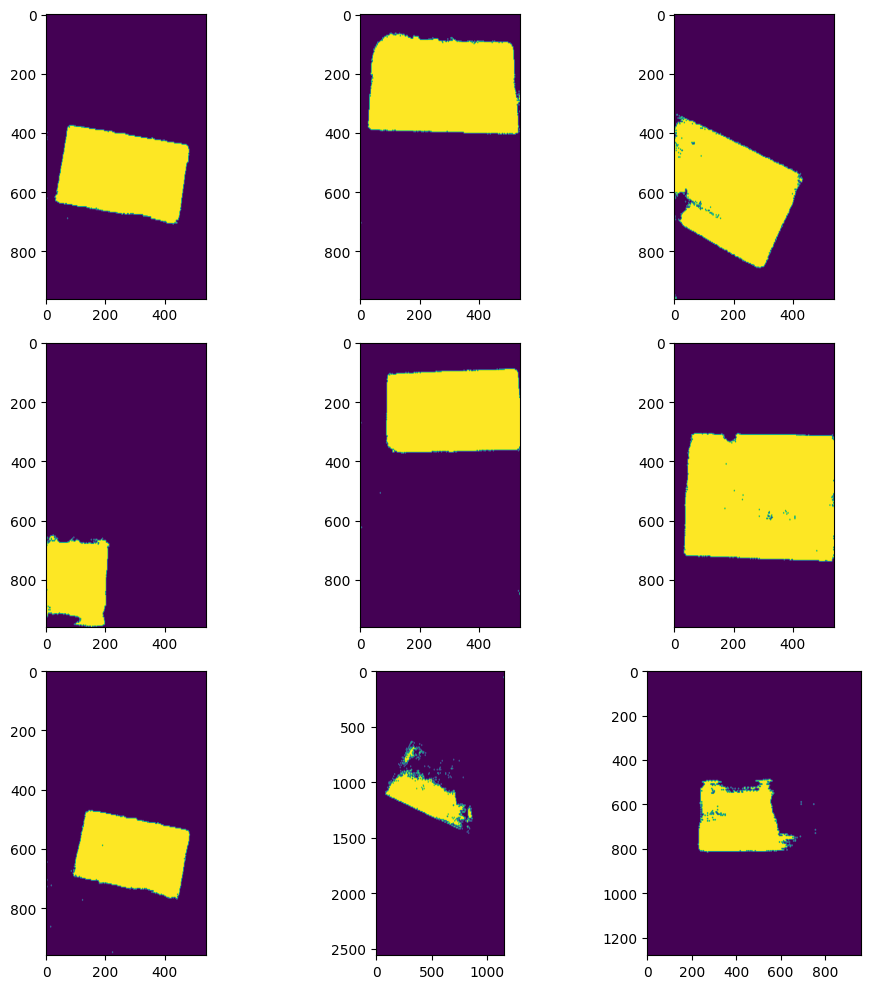

In [27]:
mask = []

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i in range(1, 10):

    INPUT_FILE = TEST_PATH + "/" + TEST_FILE + str(i) + ".png"
    img, w, h = image.load_image(INPUT_FILE)
    output = predict_image(model, img)
    mask_image = cv2.resize(output, (h, w))
    axes[(i-1)//3, (i-1)%3].imshow(mask_image)
    mask.append(mask_image)
    
plt.tight_layout()
plt.show()